
## Predict next-day rain

##  Importing tools


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMClassifier
from optuna.samplers import TPESampler
import optuna.integration.lightgbm as lightgbm
from sklearn.metrics import roc_auc_score
# import optuna
from sklearn.feature_selection import RFECV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

##  Data reading and primary processing

In [84]:
data = pd.read_csv('DatasetAUS.csv')
print(data)
import pandas as pd

# Assuming you have a DataFrame called df and you want to find unique values in a column named 'column_name'
unique_values = data['RainTomorrow'].unique()

# Print the unique values
print(unique_values)

#data.dropna(subset=['RainTomorrow'], inplace=True)
#data['RainTomorrow'] = pd.factorize(data['RainTomorrow'])[0]
#target = data['RainTomorrow']
#data = data.drop(['RainTomorrow'], axis=1)

              Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       01-12-2008   Albury     13.4     22.9       0.6          NaN   
1       02-12-2008   Albury      7.4     25.1       0.0          NaN   
2       03-12-2008   Albury     12.9     25.7       0.0          NaN   
3       04-12-2008   Albury      9.2     28.0       0.0          NaN   
4       05-12-2008   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  21-06-2017    Uluru      2.8     23.4       0.0          NaN   
145456  22-06-2017    Uluru      3.6     25.3       0.0          NaN   
145457  23-06-2017    Uluru      5.4     26.9       0.0          NaN   
145458  24-06-2017    Uluru      7.8     27.0       0.0          NaN   
145459  25-06-2017    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
0            NaN           W           44.0          W  ... 

In [78]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No


In [82]:
df=data['RainTomorrow'].unique()
print(df)

KeyError: 'RainTomorrow'

In [3]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null   fl

<Axes: xlabel='RainTomorrow', ylabel='count'>

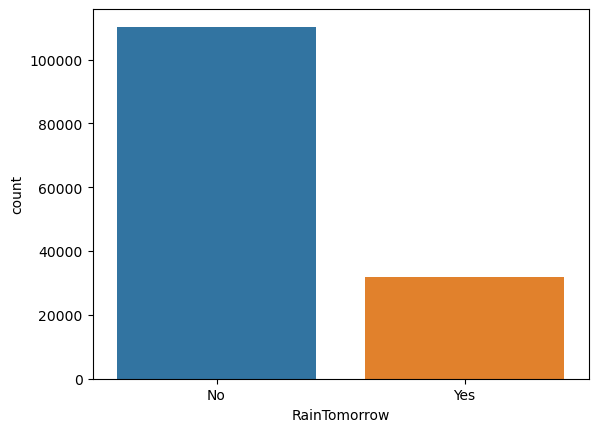

In [5]:
sns.countplot(x=data['RainTomorrow'])

<Axes: xlabel='RainToday', ylabel='count'>

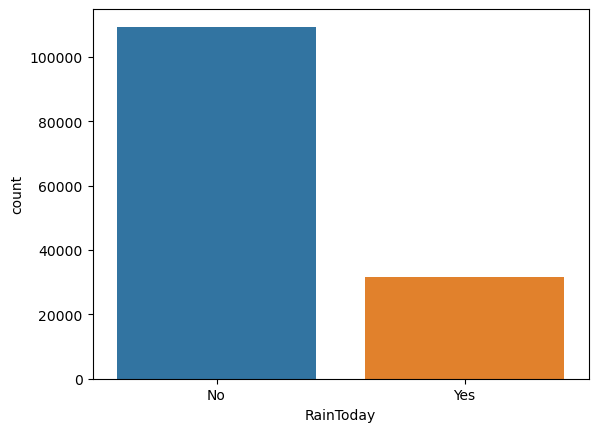

In [6]:
sns.countplot(x=data['RainToday'])

In [7]:
data['RainTomorrow'] = pd.factorize(data['RainTomorrow'])[0]
target = data['RainTomorrow']
data = data.drop(['RainTomorrow'], axis=1)

In [8]:
cat = ['Location',
       'WindGustDir',
       'WindDir9am',
       'WindDir3pm',
       'RainToday',
       'Date']
dig = [i for i in list(data) if i not in cat]

In [9]:
percent_nan = data.isna().sum()/data.shape[0]
percent_nan

Date             0.000000
Location         0.000000
MinTemp          0.004480
MaxTemp          0.002265
Rainfall         0.009888
Evaporation      0.427890
Sunshine         0.476929
WindGustDir      0.065615
WindGustSpeed    0.065193
WindDir9am       0.070418
WindDir3pm       0.026570
WindSpeed9am     0.009480
WindSpeed3pm     0.018496
Humidity9am      0.012476
Humidity3pm      0.025388
Pressure9am      0.098556
Pressure3pm      0.098324
Cloud9am         0.377353
Cloud3pm         0.401525
Temp9am          0.006358
Temp3pm          0.019171
RainToday        0.009888
dtype: float64

In [10]:
for ind, d in zip(percent_nan.index, percent_nan):
  if ind in dig and d != 0:
    data[ind].fillna(data[ind].mean(), inplace=True)

data.fillna(method='ffill', inplace=True)

C:\Users\Brijesh kumar\AppData\Local\Temp\ipykernel_12920\702989050.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [11]:
for c in cat:
  data['{}_dig'.format(c)] = pd.factorize(data[c])[0]

In [12]:
cat_dig = ['{}_dig'.format(c) for c in cat]
features = dig + cat_dig

##  Data visualization

array([[<Axes: title={'center': 'MinTemp'}>,
        <Axes: title={'center': 'MaxTemp'}>,
        <Axes: title={'center': 'Rainfall'}>,
        <Axes: title={'center': 'Evaporation'}>,
        <Axes: title={'center': 'Sunshine'}>],
       [<Axes: title={'center': 'WindGustSpeed'}>,
        <Axes: title={'center': 'WindSpeed9am'}>,
        <Axes: title={'center': 'WindSpeed3pm'}>,
        <Axes: title={'center': 'Humidity9am'}>,
        <Axes: title={'center': 'Humidity3pm'}>],
       [<Axes: title={'center': 'Pressure9am'}>,
        <Axes: title={'center': 'Pressure3pm'}>,
        <Axes: title={'center': 'Cloud9am'}>,
        <Axes: title={'center': 'Cloud3pm'}>,
        <Axes: title={'center': 'Temp9am'}>],
       [<Axes: title={'center': 'Temp3pm'}>,
        <Axes: title={'center': 'Location_dig'}>,
        <Axes: title={'center': 'WindGustDir_dig'}>,
        <Axes: title={'center': 'WindDir9am_dig'}>,
        <Axes: title={'center': 'WindDir3pm_dig'}>],
       [<Axes: title={'center

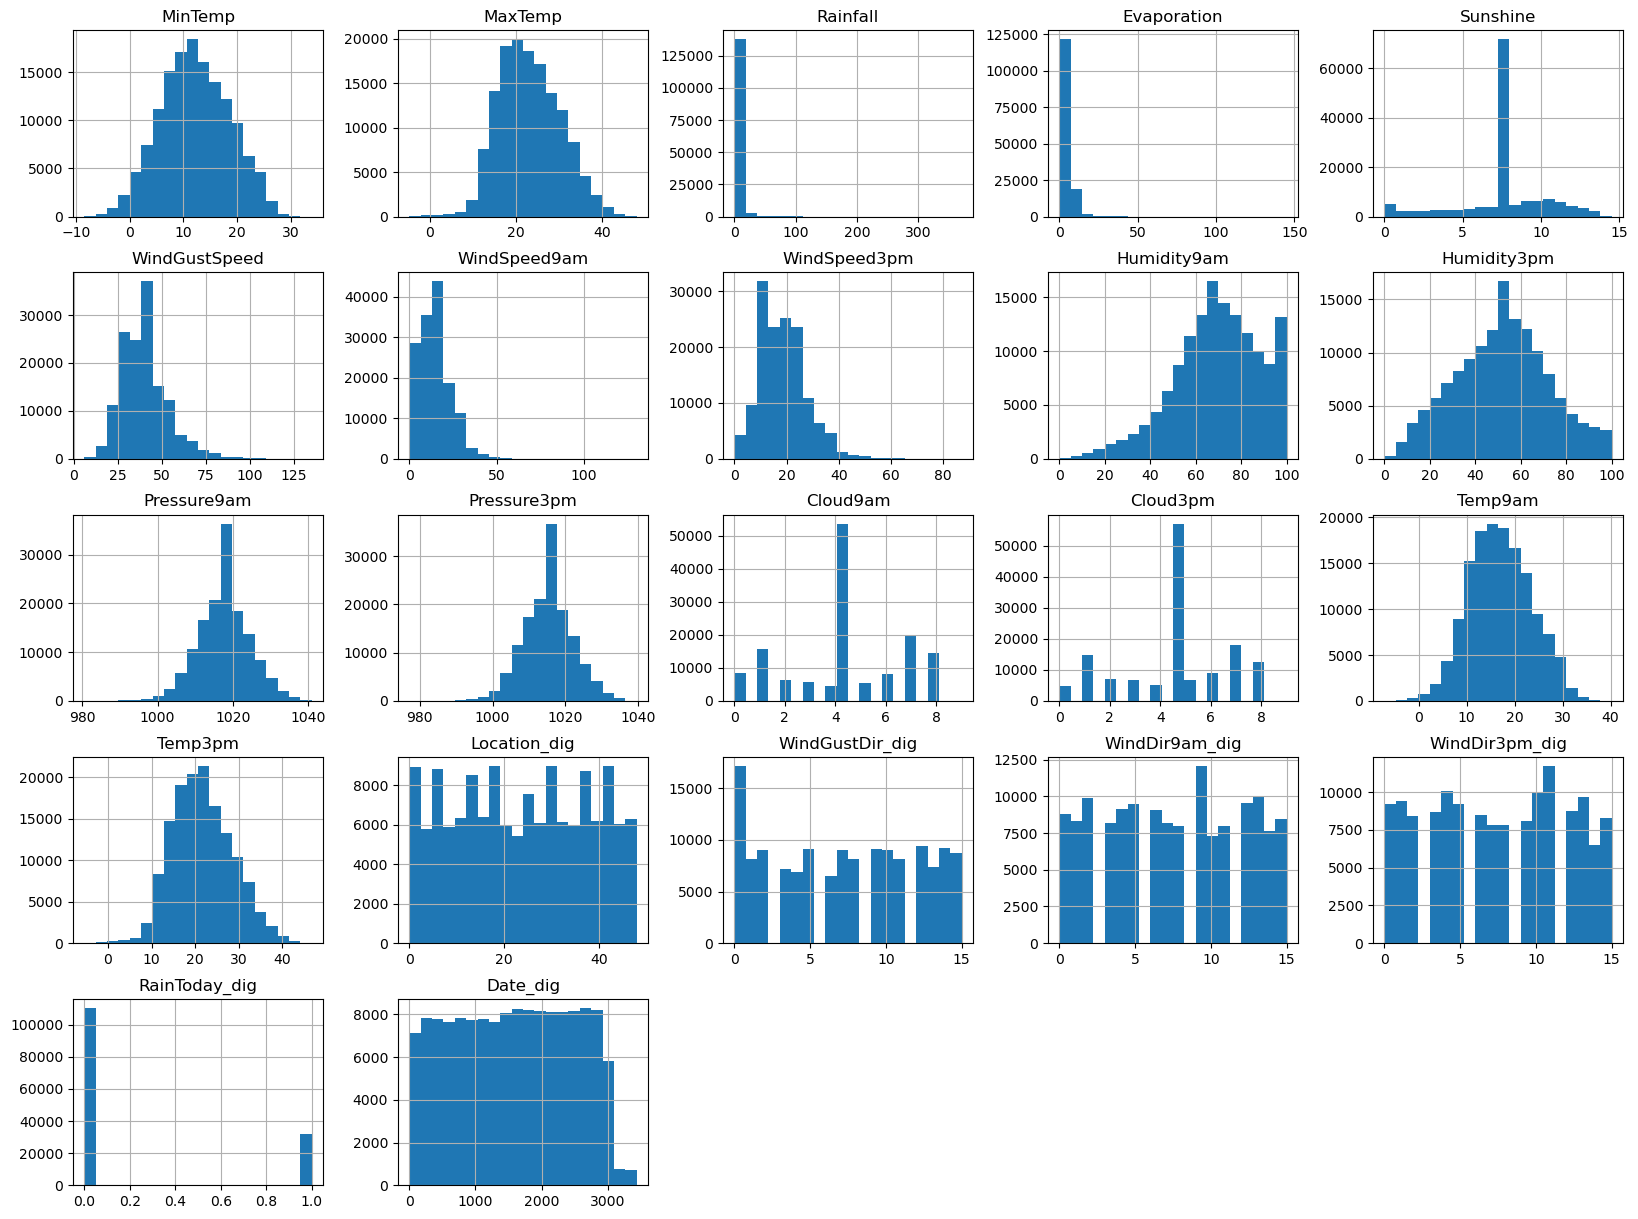

In [13]:
data[features].hist(figsize=(20, 15), bins=20)

In [14]:
data[features].corrwith(target)

MinTemp            0.083717
MaxTemp           -0.159087
Rainfall           0.236874
Evaporation       -0.089551
Sunshine          -0.327029
WindGustSpeed      0.225264
WindSpeed9am       0.090524
WindSpeed3pm       0.086909
Humidity9am        0.255158
Humidity3pm        0.439678
Pressure9am       -0.234027
Pressure3pm       -0.214688
Cloud9am           0.253832
Cloud3pm           0.301841
Temp9am           -0.025582
Temp3pm           -0.190286
Location_dig      -0.009608
WindGustDir_dig   -0.062894
WindDir9am_dig     0.012540
WindDir3pm_dig    -0.012167
RainToday_dig      0.309922
Date_dig          -0.012478
dtype: float64

In [15]:
drop_features = []

for feature, corr in zip(data[features].corrwith(target).index, data[features].corrwith(target).values):
    if np.abs(corr) < 0.05:
        drop_features.append(feature)

##  Data standardization

In [16]:
for d in dig:
  data[d] = (data[d] - data[d].mean()) / data[d].std()

array([[<Axes: title={'center': 'MinTemp'}>,
        <Axes: title={'center': 'MaxTemp'}>,
        <Axes: title={'center': 'Rainfall'}>,
        <Axes: title={'center': 'Evaporation'}>],
       [<Axes: title={'center': 'Sunshine'}>,
        <Axes: title={'center': 'WindGustSpeed'}>,
        <Axes: title={'center': 'WindSpeed9am'}>,
        <Axes: title={'center': 'WindSpeed3pm'}>],
       [<Axes: title={'center': 'Humidity9am'}>,
        <Axes: title={'center': 'Humidity3pm'}>,
        <Axes: title={'center': 'Pressure9am'}>,
        <Axes: title={'center': 'Pressure3pm'}>],
       [<Axes: title={'center': 'Cloud9am'}>,
        <Axes: title={'center': 'Cloud3pm'}>,
        <Axes: title={'center': 'Temp9am'}>,
        <Axes: title={'center': 'Temp3pm'}>]], dtype=object)

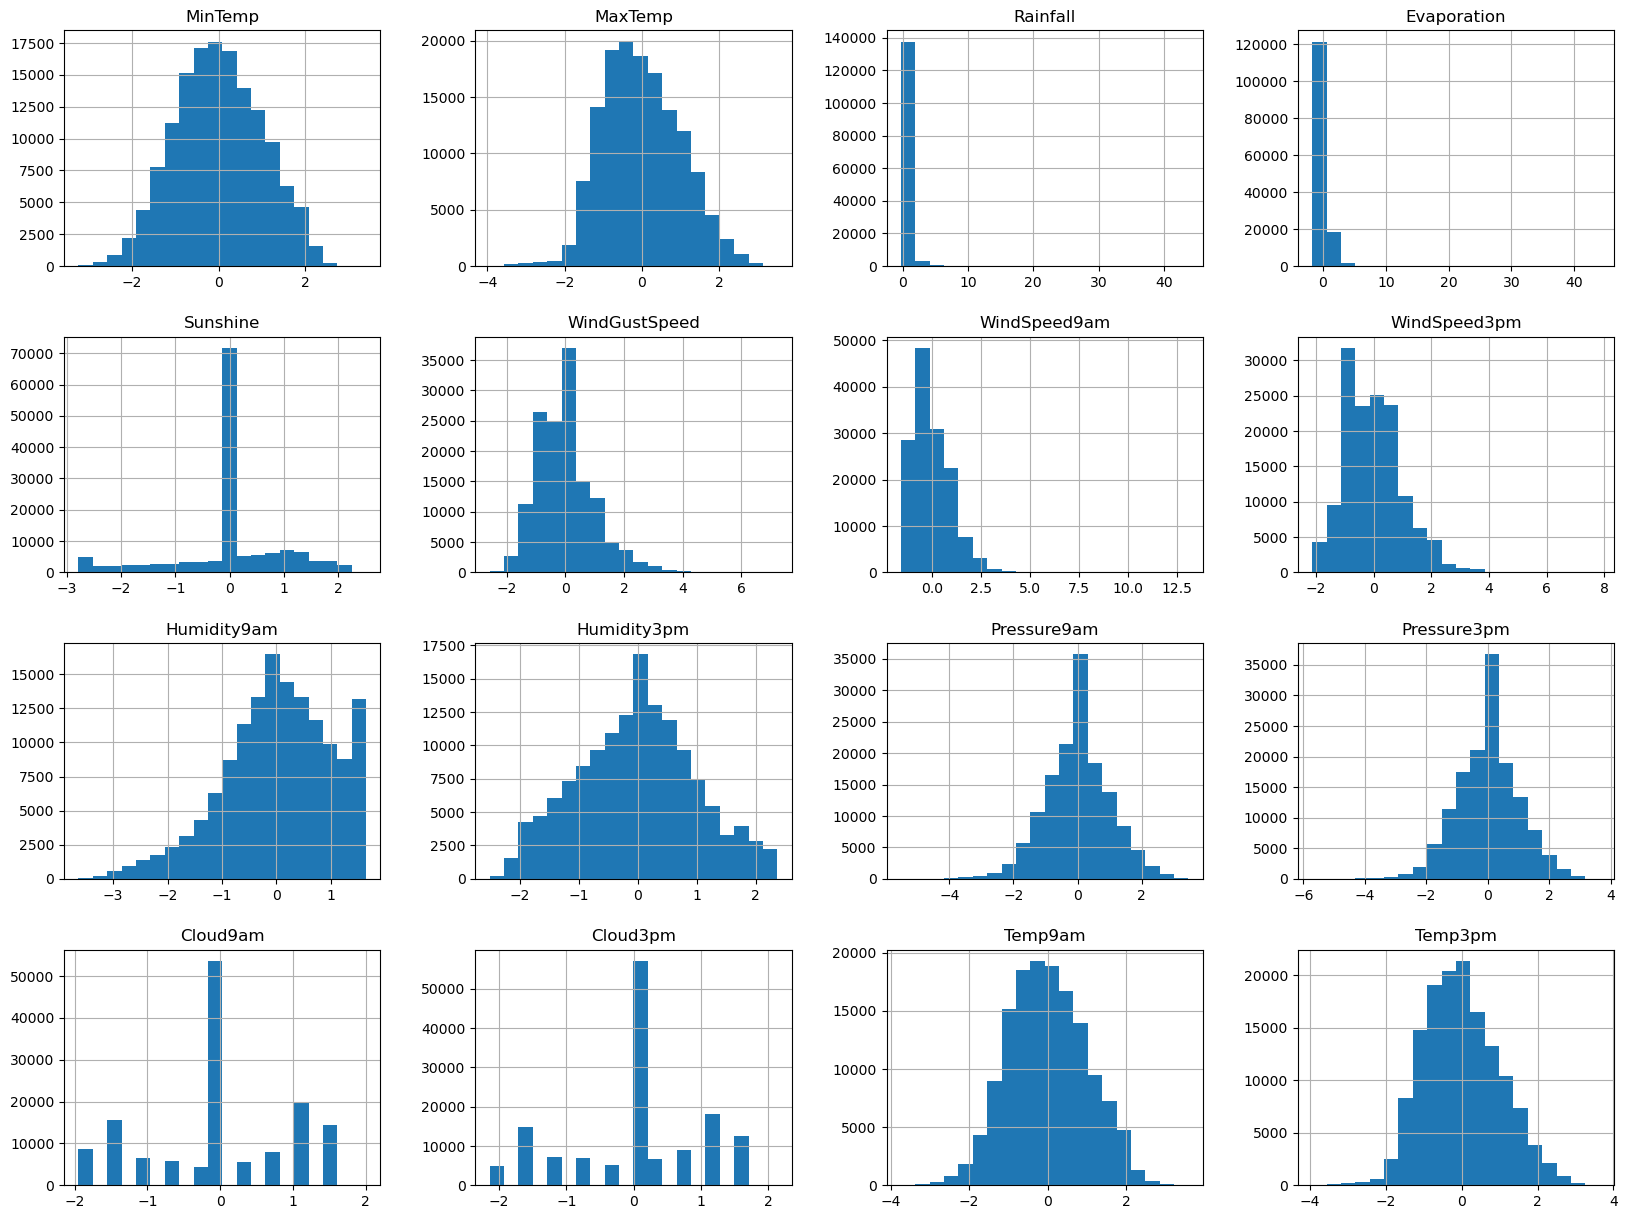

In [17]:
data[dig].hist(figsize=(20, 15), bins=20)

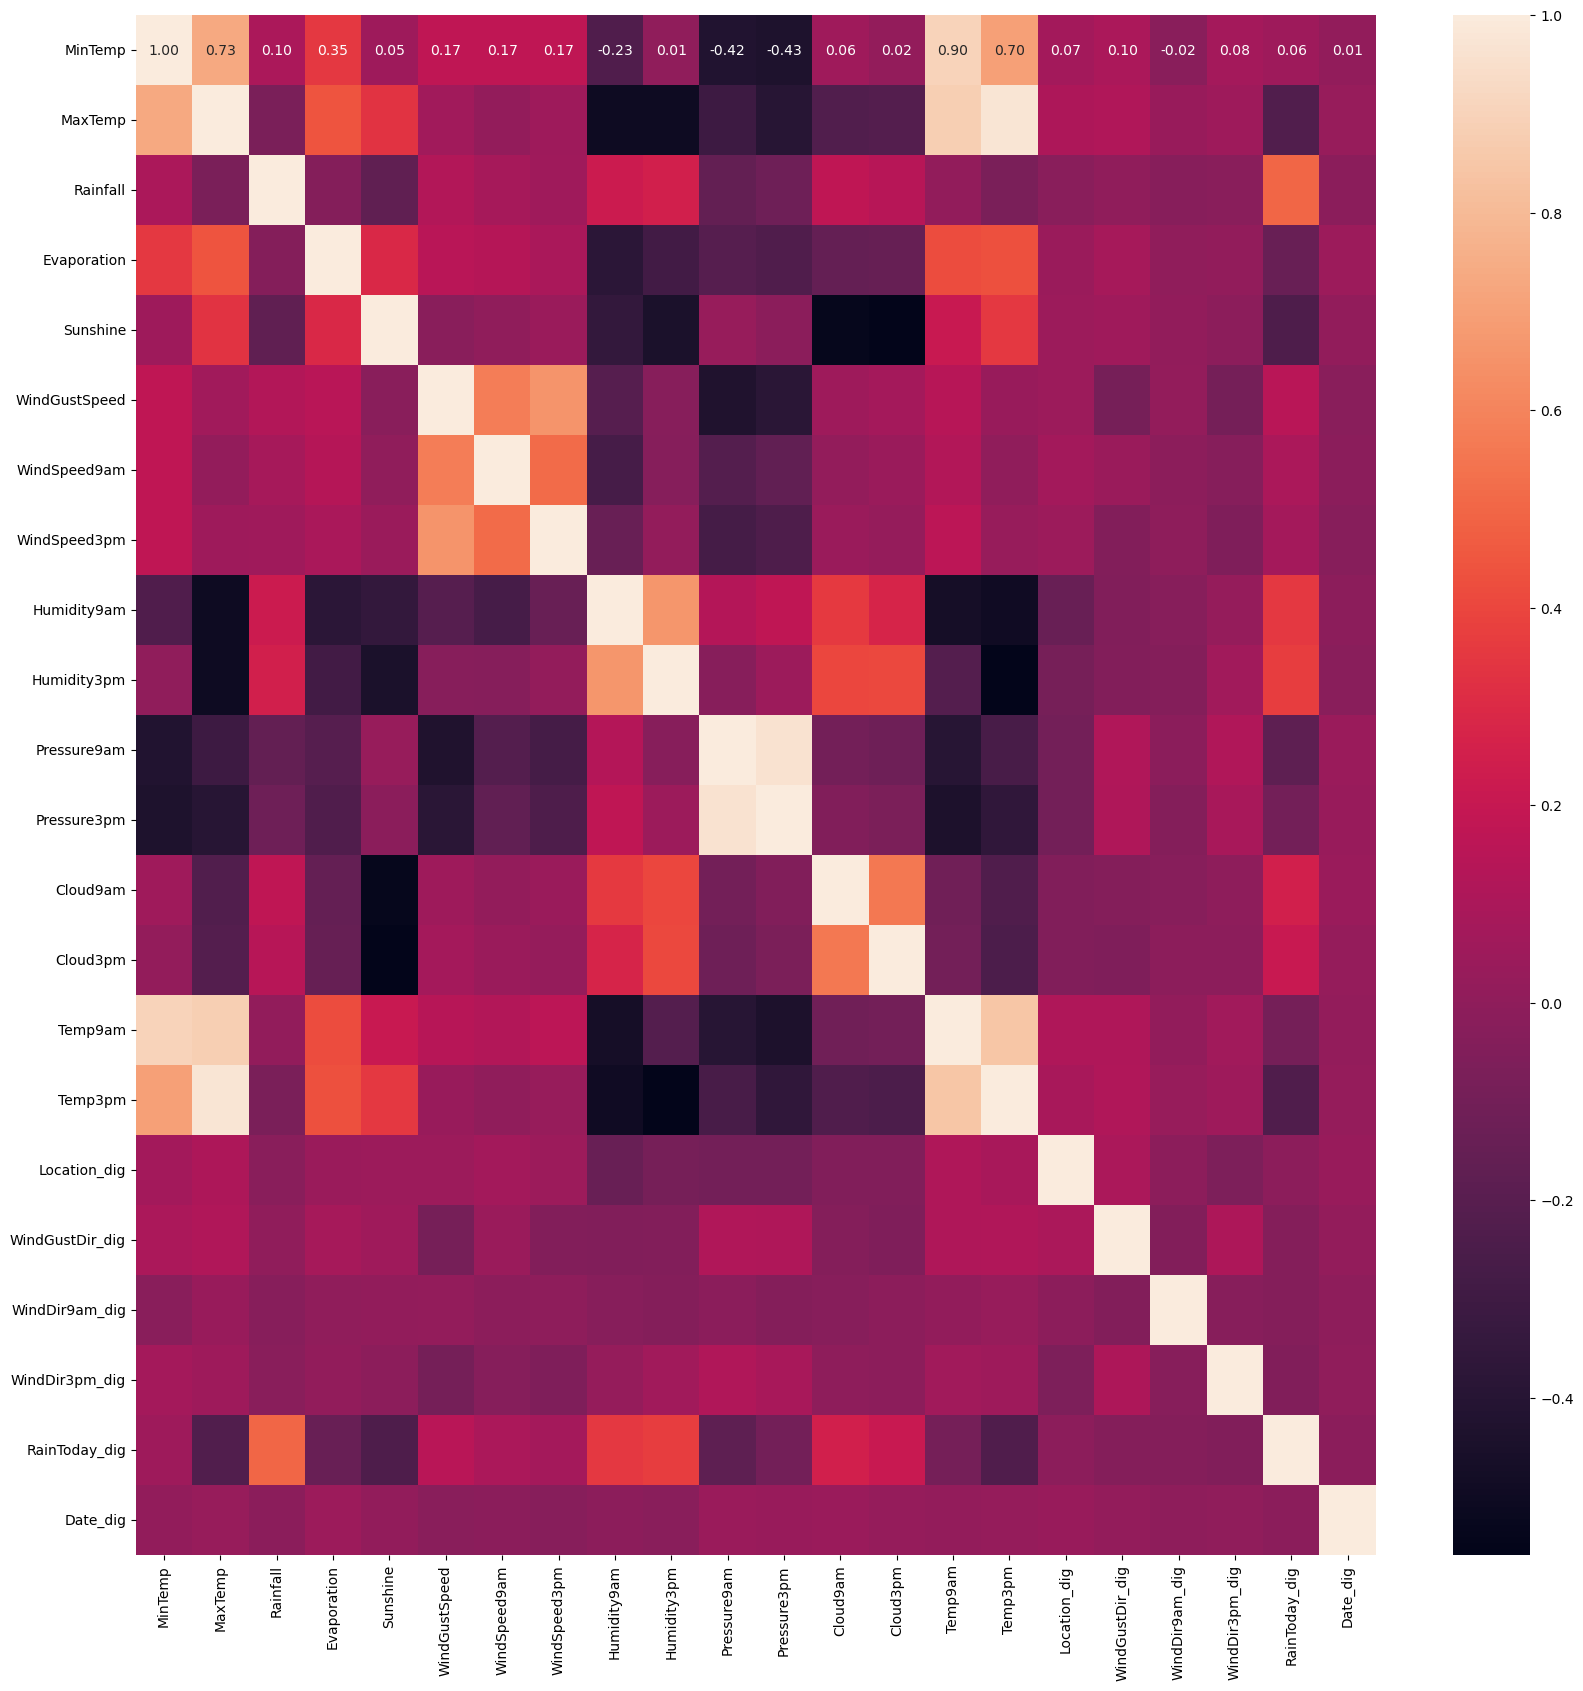

In [18]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=np.number)

# Calculate the correlation matrix for numeric columns
plt.figure(figsize=(20, 20))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f')
plt.show()

#numeric_data = data.select_dtypes(include=['number'])
#data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
#data = data.drop(columns=['Date'])
#print(data.dtypes)
#plt.figure(figsize=(20, 20))
#sns.heatmap(data.corr(), annot=True, fmt='.2f')
#plt.show()
#plt.figure(figsize=(20,20))
#sns.heatmap(data.corr(), annot= True, fmt='.2f')

## 3. Model selection

In [19]:
new_features = [feature for feature in features if feature not in drop_features]

In [20]:
xtrain, xtest, ytrain, ytest = train_test_split(
    data[new_features], target, random_state=100, test_size=0.2, shuffle=False)

In [21]:
eval_set = [(xtrain, ytrain), (xtest, ytest)]

### XGBoost

In [22]:
xgbmodel = xgb.XGBClassifier(seed=123)
xgbmodel.fit(xtrain, ytrain,eval_metric=["error", "logloss"], eval_set=eval_set)
xgbmodel.score(xtest, ytest)

C:\Users\Brijesh kumar\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.21267	validation_0-logloss:0.46347	validation_1-error:0.19030	validation_1-logloss:0.43645
[1]	validation_0-error:0.17563	validation_0-logloss:0.42565	validation_1-error:0.15785	validation_1-logloss:0.39869
[2]	validation_0-error:0.16392	validation_0-logloss:0.40222	validation_1-error:0.14726	validation_1-logloss:0.37486
[3]	validation_0-error:0.16003	validation_0-logloss:0.38716	validation_1-error:0.14339	validation_1-logloss:0.35838
[4]	validation_0-error:0.15793	validation_0-logloss:0.37704	validation_1-error:0.14174	validation_1-logloss:0.34696
[5]	validation_0-error:0.15609	validation_0-logloss:0.36941	validation_1-error:0.14034	validation_1-logloss:0.33924
[6]	validation_0-error:0.15541	validation_0-logloss:0.36412	validation_1-error:0.13914	validation_1-logloss:0.33336
[7]	validation_0-error:0.15475	validation_0-logloss:0.36010	validation_1-error:0.13830	validation_1-logloss:0.32927
[8]	validation_0-error:0.15262	validation_0-logloss:0.35587	validation_1

0.8607545975596892

Accuracy: 86.08%


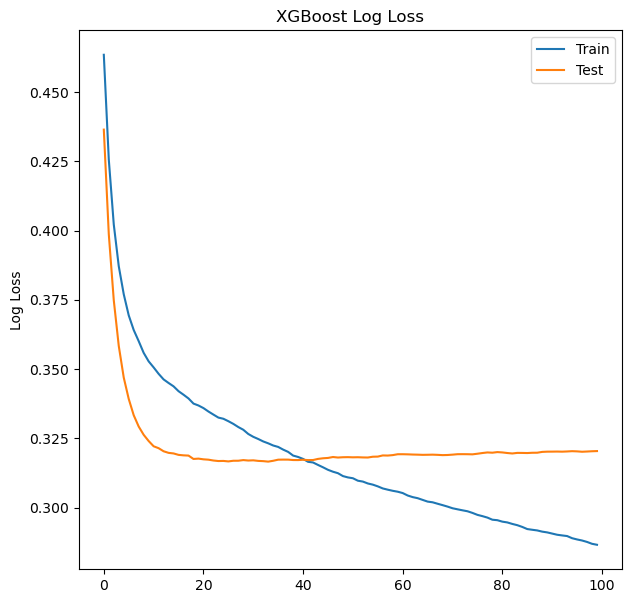

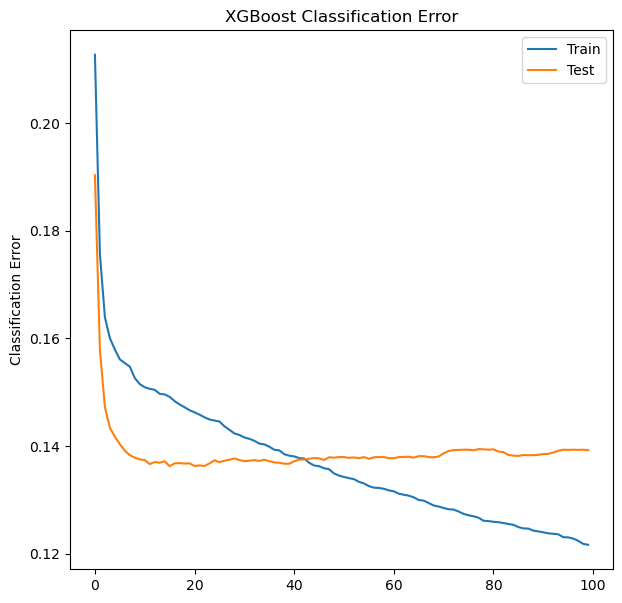

In [23]:
    from sklearn.metrics import accuracy_score
    from matplotlib import pyplot
    import matplotlib.pyplot as plt

    y_pred = xgbmodel.predict(xtest)
    predictions = [round(value) for value in y_pred]

    # evaluate predictions
    accuracy = accuracy_score(ytest, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    # retrieve performance metrics
    results = xgbmodel.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

    # plot log loss
    fig, ax = pyplot.subplots(figsize=(7,7))
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()

    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()


    # plot classification error
    fig, ax = pyplot.subplots(figsize=(7,7))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()

    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[21413  1283]
 [ 2677  3066]]


Accuracy Score of the model is: 0.8607545975596892
Confusion matrix is: 
 Axes(0.125,0.11;0.62x0.77)
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     22696
           1       0.70      0.53      0.61      5743

    accuracy                           0.86     28439
   macro avg       0.80      0.74      0.76     28439
weighted avg       0.85      0.86      0.85     28439



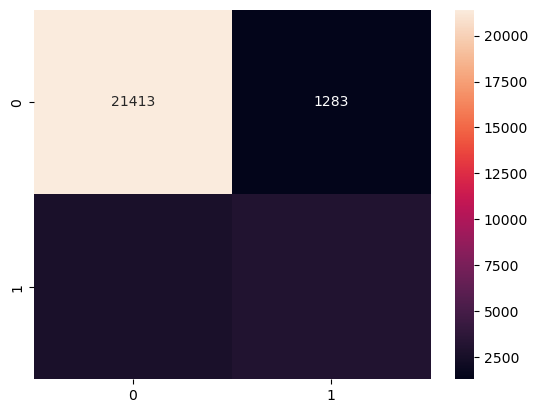

In [25]:
from sklearn.metrics import classification_report

print(f'Accuracy Score of the model is: {accuracy_score(ytest,predictions)}')
print(f"Confusion matrix is: \n {sns.heatmap(confusion_matrix(ytest,predictions), annot = True, fmt = 'd')}")
print(classification_report(ytest, predictions))
acc_xgboost = accuracy_score(ytest,predictions)

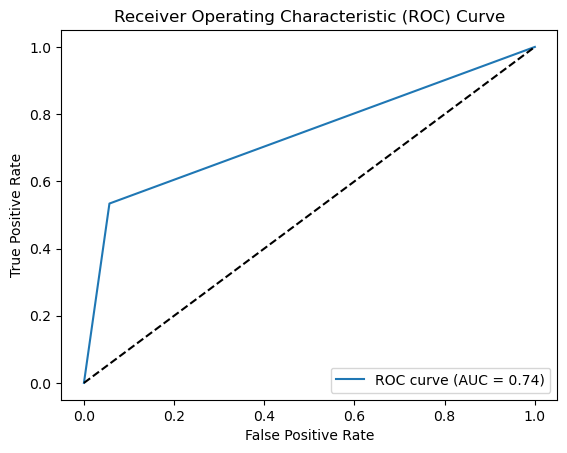

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming predictions_c and r_ytest are in the appropriate format

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(ytest,predictions)

# Calculate the AUC-ROC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### LGBM Classfier

In [27]:
eval_set = [(xtrain, ytrain), (xtest, ytest)]

In [28]:
lgb_model = LGBMClassifier(random_state=123,eval_metric=["error", "logloss"], eval_set=eval_set)
lgb_model.fit(xtrain, ytrain)
lgb_model.score(xtest, ytest)
y_pred = lgb_model.predict(xtest)
predictions_l = [round(value) for value in y_pred]

[LightGBM] [Warning] 1.453474e+00 is set=, 1.453474e+00= will be ignored. Current value: 1.453474e+00=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] -0.630877 is set=, -0.630877= will be ignored. Current value: -0.630877=
[LightGBM] [Warning] Humidity3pm is set=, Humidity3pm= will be ignored. Current value: Humidity3pm=
[LightGBM] [Warning] Name: is set=, Name:= will be ignored. Current value: Name:=
[LightGBM] [Warning] WindGustDir_dig is set=, WindGustDir_dig= will be ignored. Current value: WindGustDir_dig=
[LightGBM] [Warning] MinTemp is set=, MinTemp= will be ignored. Current value: MinTemp=
[LightGBM] [Warning] 4 is set=, 4= will be ignored. Current value: 4=
[LightGBM] 

Accuracy Score of the model is: 0.8638137768557262
Confusion matrix is: 
 Axes(0.125,0.11;0.62x0.77)
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22696
           1       0.73      0.52      0.61      5743

    accuracy                           0.86     28439
   macro avg       0.81      0.74      0.76     28439
weighted avg       0.85      0.86      0.85     28439

0.8638137768557262


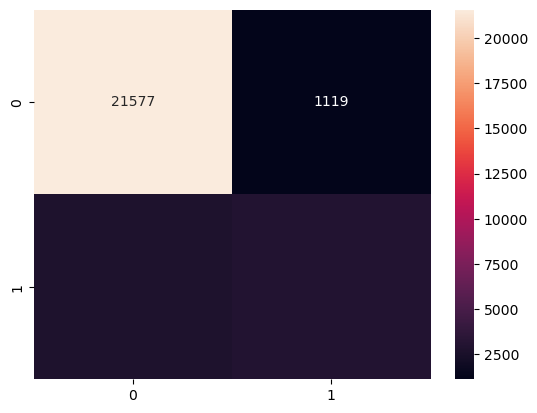

In [29]:
from sklearn.metrics import classification_report
print(f'Accuracy Score of the model is: {accuracy_score(ytest,predictions_l)}')
print(f"Confusion matrix is: \n {sns.heatmap(confusion_matrix(ytest,predictions_l), annot = True, fmt = 'd')}")
print(classification_report(ytest, predictions_l))
acc_lgbm = accuracy_score(ytest,predictions_l)
print(acc_lgbm)

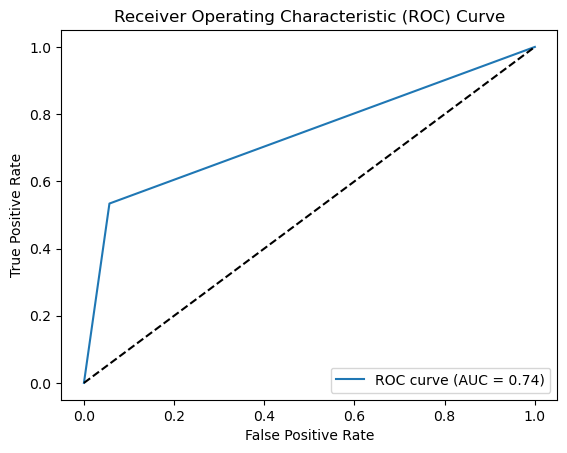

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming predictions_c and r_ytest are in the appropriate format

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(ytest,predictions)

# Calculate the AUC-ROC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, predictions)


# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[21413  1283]
 [ 2677  3066]]


##  Ensemble of models

In [32]:
k = KNeighborsClassifier(n_neighbors=7)
g = GaussianNB()
rf = RandomForestClassifier()

estimators = [
    ('xg',xgbmodel),('k', k), ('l', lgb_model), ('rf', rf),( 'g',g)
]

In [33]:
k.fit(xtrain, ytrain)
k.score(xtest, ytest)


0.8435247371567214

In [34]:
k.fit(xtest, ytest)


KNeighborsClassifier(n_neighbors=7)

In [35]:
y_pred_k = k.predict(xtest)
predictions_k = [round(value) for value in y_pred_k]

accuracy_k = accuracy_score(ytest, predictions_k)


In [36]:
g.fit(xtrain, ytrain)
g.score(xtest, ytest)
g.fit(xtest, ytest)


GaussianNB()

In [37]:
y_pred_g = g.predict(xtest)
predictions_g = [round(value) for value in y_pred_g]

accuracy_g = accuracy_score(ytest, predictions_g)
print(accuracy_g)


0.8249586834980133


In [38]:
rf.fit(xtrain, ytrain)
rf.score(xtest, ytest)

0.8606139456380323

In [39]:
rf.fit(xtest, ytest)


RandomForestClassifier()

In [40]:
y_pred_rf = rf.predict(xtest)
#predictions_rf = [round(value) for value in y_pred_rf]

accuracy_rf = accuracy_score(ytest, y_pred_rf)
print(accuracy_rf)


0.9999296740391715


Further, combine them.

In [41]:
vote = VotingClassifier(voting='hard', estimators=estimators)
vote.fit(xtrain, ytrain)
vote.score(xtest, ytest)

[LightGBM] [Warning] 1.453474e+00 is set=, 1.453474e+00= will be ignored. Current value: 1.453474e+00=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] -0.630877 is set=, -0.630877= will be ignored. Current value: -0.630877=
[LightGBM] [Warning] Humidity3pm is set=, Humidity3pm= will be ignored. Current value: Humidity3pm=
[LightGBM] [Warning] Name: is set=, Name:= will be ignored. Current value: Name:=
[LightGBM] [Warning] WindGustDir_dig is set=, WindGustDir_dig= will be ignored. Current value: WindGustDir_dig=
[LightGBM] [Warning] MinTemp is set=, MinTemp= will be ignored. Current value: MinTemp=
[LightGBM] [Warning] 4 is set=, 4= will be ignored. Current value: 4=
[LightGBM] 

0.8634621470515841

In [42]:
vote.fit(xtest, ytest)


[LightGBM] [Warning] 1.453474e+00 is set=, 1.453474e+00= will be ignored. Current value: 1.453474e+00=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] -0.630877 is set=, -0.630877= will be ignored. Current value: -0.630877=
[LightGBM] [Warning] Humidity3pm is set=, Humidity3pm= will be ignored. Current value: Humidity3pm=
[LightGBM] [Warning] Name: is set=, Name:= will be ignored. Current value: Name:=
[LightGBM] [Warning] WindGustDir_dig is set=, WindGustDir_dig= will be ignored. Current value: WindGustDir_dig=
[LightGBM] [Warning] MinTemp is set=, MinTemp= will be ignored. Current value: MinTemp=
[LightGBM] [Warning] 4 is set=, 4= will be ignored. Current value: 4=
[LightGBM] 

VotingClassifier(estimators=[('xg',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
145458     0.258846     0.185848 -0.630877 -1.189318e+00  0.627697   

        WindGustDir_dig  RainToday_dig  
116652                2              1  
116653                7              0  
116655                2              0  
116656                2              1  
116657               14              0  
...                 ...            ...  
145454               14              0  
145455               14              0  
145456                4              0  
145457                5              0  
145458               12              0  

[28439 rows x 17 columns],
                                                        116652    0
116653    0
116655    1
116656    0
116657    0
         ..
145454    0
145455    0
145456    0
145457    0
145458    0
Name: RainTomorrow, Length: 28439, dtype: int64)],
                                             random_state=123)),
                             ('rf', RandomForestClassifier()),
                             ('g', GaussianNB())])

In [43]:
y_pred_v = vote.predict(xtest)
predictions_v = [round(value) for value in y_pred_v]

accuracy_v = accuracy_score(ytest, predictions_v)


[LightGBM] [Warning] 1.453474e+00 is set=, 1.453474e+00= will be ignored. Current value: 1.453474e+00=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] 116648 is set=, 116648= will be ignored. Current value: 116648=
[LightGBM] [Warning] -0.630877 is set=, -0.630877= will be ignored. Current value: -0.630877=
[LightGBM] [Warning] Humidity3pm is set=, Humidity3pm= will be ignored. Current value: Humidity3pm=
[LightGBM] [Warning] Name: is set=, Name:= will be ignored. Current value: Name:=
[LightGBM] [Warning] WindGustDir_dig is set=, WindGustDir_dig= will be ignored. Current value: WindGustDir_dig=
[LightGBM] [Warning] MinTemp is set=, MinTemp= will be ignored. Current value: MinTemp=
[LightGBM] [Warning] 4 is set=, 4= will be ignored. Current value: 4=
[LightGBM] 

Accuracy Score of the model is: 0.9279158901508492
Confusion matrix is: 
 Axes(0.125,0.11;0.62x0.77)
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     22696
           1       0.90      0.73      0.80      5743

    accuracy                           0.93     28439
   macro avg       0.92      0.85      0.88     28439
weighted avg       0.93      0.93      0.92     28439



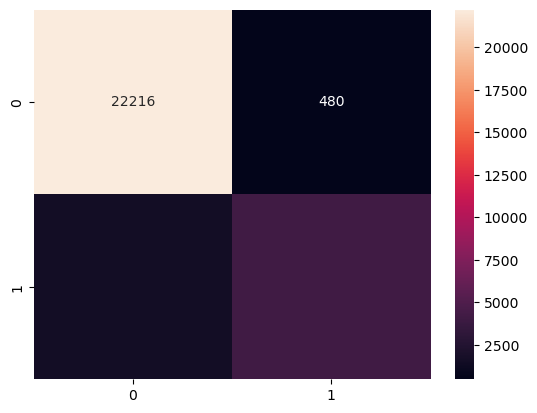

In [44]:
from sklearn.metrics import classification_report
print(f'Accuracy Score of the model is: {accuracy_score(ytest,predictions_v)}')
print(f"Confusion matrix is: \n {sns.heatmap(confusion_matrix(ytest,predictions_v), annot = True, fmt = 'd')}")
print(classification_report(ytest, predictions_v))
acc_ensemble=accuracy_score(ytest,predictions_v)

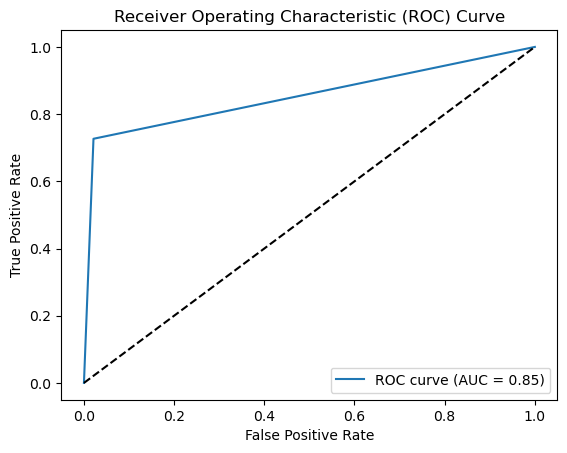

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming predictions_c and r_ytest are in the appropriate format

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(ytest,predictions_v)

# Calculate the AUC-ROC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, predictions_v)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[22216   480]
 [ 1570  4173]]


saving model

In [47]:
import joblib
filename = 'xgbmodel.sav'
joblib.dump(xgbmodel, filename)

['xgbmodel.sav']

In [48]:
filename = 'lgb_model.sav'
joblib.dump(lgb_model, filename)

['lgb_model.sav']

In [49]:
import joblib
filename = 'k.sav'

joblib.dump(k, filename)

['k.sav']

In [50]:
filename = 'vote.sav'

joblib.dump(vote, filename)

['vote.sav']

Load model

In [51]:
import joblib
xgbmodel = joblib.load('xgbmodel.sav')

In [52]:
lgb_model = joblib.load('lgb_model.sav')


## Recurrent Neural Network (RNN)

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras import layers
from tensorflow.keras.optimizers import Adam
import numpy as np

In [54]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


In [55]:
k = 30 # for best result, you may increase k value

r_xtrain = [xtrain.iloc[i:i+k] for i in range(xtrain.shape[0]-k-1)]
r_ytrain = [ytrain.iloc[i+k] for i in range(ytrain.shape[0]-k-1)]

r_xtest = [xtest.iloc[i:i+k] for i in range(xtest.shape[0]-k-1)]
r_ytest = [ytest.iloc[i+k] for i in range(xtest.shape[0]-k-1)]

r_xtrain = np.array(r_xtrain)
r_ytrain = np.array(r_ytrain)

r_xtest = np.array(r_xtest)
r_ytest = np.array(r_ytest)

Lets create a simple 1-layer RNN.

In [56]:
with tf.device('/cpu:0'):
    model = models.Sequential()

    model.add(layers.GRU(32, input_shape=(None, r_xtrain.shape[-1]), recurrent_dropout=0.2))
    # model.add(layers.GRU(16, input_shape=(None, r_xtrain.shape[-1]), recurrent_dropout=0.2))
    model.add(layers.Dense(1))
    model.compile(optimizer=Adam(amsgrad=True), loss='mse', metrics=['accuracy'])
    history = model.fit(x=r_xtrain,
                        y=r_ytrain,
                        epochs=15,
                        validation_data=(r_xtest, r_ytest)
                        )

C:\Users\Brijesh kumar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.7682 - loss: 0.1723 - val_accuracy: 0.8057 - val_loss: 0.1372
Epoch 2/15
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 69s 19ms/step - accuracy: 0.7768 - loss: 0.1597 - val_accuracy: 0.8099 - val_loss: 0.1373
Epoch 3/15
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 73s 21ms/step - accuracy: 0.7801 - loss: 0.1563 - val_accuracy: 0.8091 - val_loss: 0.1360
Epoch 4/15
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 68s 19ms/step - accuracy: 0.7821 - loss: 0.1547 - val_accuracy: 0.8112 - val_loss: 0.1339
Epoch 5/15
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 71s 20ms/step - accuracy: 0.7840 - loss: 0.1536 - val_accuracy: 0.8111 - val_loss: 0.1383
Epoch 6/15
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 67s 19ms/step - accuracy: 0.7828 - loss: 0.1535 - val_accuracy: 0.8115 - val_loss: 0.1345
Epoch 7/15
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 68s 19ms/step - accuracy: 0.7843 - loss: 0.1521 - val_accuracy: 0.8116 - val_loss: 0.1377
Epoch 8/15
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 70s 20ms/step - accuracy: 0.7845 -

In [57]:
import pickle

# Specify the file path including a file name where you want to save the training history
file_path = 'D:/Project/rnn_train_hist.pkl'

# Open the file in binary write mode ('wb')
with open(file_path, 'wb') as rnn_history:
    pickle.dump(model.history.history, rnn_history)


In [58]:
import pickle
with open('D:/Project/rnn_train_hist.pkl', 'wb') as rnn_history:
        pickle.dump(model.history.history, rnn_history)

Plots the history process.

In [59]:
def history_plt(history):
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(epochs, acc, label='acc', color='b')
    ax[0].plot(epochs, val_acc, label='val_acc', color='r')
    ax[0].legend()
    ax[1].plot(epochs, loss, label='loss', color='b')
    ax[1].plot(epochs, val_loss, label='val_loss', color='r')
    ax[1].legend()
    plt.show()

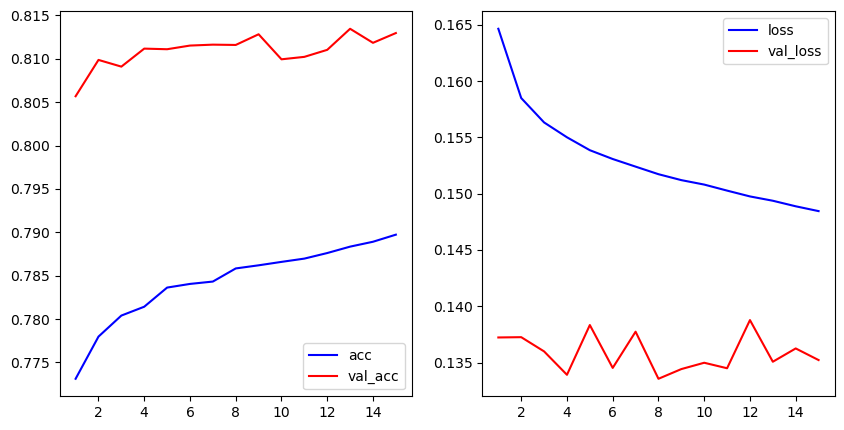

In [60]:
history_plt(history)

In [61]:
np.max(history.history['val_accuracy'])

0.8134680390357971

In [64]:
#filename = "D:/master's/Dissertation/Dataset/weatherAUS.csv"

#joblib.dump(model, filename)
import joblib
from keras.models import load_model
from keras.layers import Dense
from keras.initializers import RandomNormal

# Assuming 'model' is your Keras model
# Define a named function for the initializer
def my_initializer(shape, dtype=None):
    return RandomNormal(mean=0.0, stddev=0.05)(shape, dtype=dtype)

# Set the kernel_initializer to the named function
model.add(Dense(64, kernel_initializer=my_initializer))

# Save the model using joblib
# Save the model using Keras's built-in save method
# Save the model using Keras's built-in save method with a .keras extension
model.save("D:/master's/Dissertation/Dataset/weatherAUS_model.keras")


#filename = "D:/master's/Dissertation/Dataset/weatherAUS.pkl"
#joblib.dump(model, filename)

In [74]:

#predictions =(model.predict(r_xtest)>0.5).astype("int32")

#from sklearn.metrics import classification_report

#print(classification_report(r_ytest, predictions))
#acc_rnn=accuracy_score(r_ytest,predictions)
#print(acc_rnn)
# Adjust the threshold for binary predictions
from sklearn.metrics import accuracy_score, classification_report

# Handle binary classification
threshold = 0.5
binary_predictions = (model.predict(r_xtest) > threshold).round()

# Check if original labels (r_ytest) are binary
if len(r_ytest.shape) == 1 or r_ytest.shape[1] == 1:
  # Binary case - use original labels directly
  r_ytest_binary = r_ytest
else:
  # Multi-class or multi-label case - handle separately
  raise ValueError("Classification metrics can't handle converting multi-class/multi-label targets to binary with thresholding.")

# Print classification report and accuracy score
print(classification_report(r_ytest_binary, binary_predictions))
acc_rnn = accuracy_score(r_ytest_binary, binary_predictions)
print("Accuracy:", acc_rnn)



888/888 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming predictions_c and r_ytest are in the appropriate format

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(r_ytest, predictions)

# Calculate the AUC-ROC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(r_ytest, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

## Convolutional Neural Network (CNN)

In [ ]:
with tf.device('/cpu:0'):
    cnn_model = models.Sequential()

    cnn_model.add(layers.Conv1D(16, 3, input_shape=(None, r_xtrain.shape[-1]), activation='relu', kernel_regularizer='l1_l2'))
    cnn_model.add(layers.Conv1D(32, 3, activation='relu', kernel_regularizer='l1_l2'))

    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(layers.MaxPool1D())

    cnn_model.add(layers.Conv1D(64, 3, activation='relu', kernel_regularizer='l1_l2'))
    cnn_model.add(layers.Conv1D(128, 3, activation='relu', kernel_regularizer='l1_l2'))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(layers.MaxPool1D())

    cnn_model.add(layers.Dense(1))
    cnn_model.compile(optimizer=Adam(amsgrad=True), loss='mse', metrics='accuracy')
    history = cnn_model.fit(x=r_xtrain,
                        y=r_ytrain,
                        epochs=15,
                        validation_data=(r_xtest, r_ytest)
                        )

In [ ]:
history_plt(history)

In [ ]:
np.max(history.history['val_accuracy'])

In [ ]:
from sklearn.metrics import classification_report

predictions_c = cnn_model.predict(r_xtest)
multiclass_predictions_c = np.argmax(predictions_c, axis=1)
print(classification_report(r_ytest, multiclass_predictions_c))

acc_cnn = accuracy_score(r_ytest, multiclass_predictions_c)  # Round predictions to the nearest integer
print(acc_cnn)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming predictions_c and r_ytest are in the appropriate format

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(r_ytest, multiclass_predictions_c)

# Calculate the AUC-ROC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import joblib
filename = 'drive/MyDrive/cnn_model.sav'
joblib.dump(model, filename)

In [ ]:
import pickle
with open('/content/drive/My Drive/cnn_train_hist', 'wb') as cnn_history:
        pickle.dump(model.history.history, cnn_history)

## Final accuracy





    * Ensemble of [RFC, KNC, GNB, LGBM, XGBoost]: 0.9254
    * XGBClassifier: 0.8625
    * LGBMClassifier: 0.8652
    * RandomForestClassifier: 0.8619
    * KNeighborsClassifier: 0.8884
    * GaussianNB: 0.8249
    * Reccurent Neural Network: 0.7979
    * Convolutional Neural Network: 0.6105

## Accuracy Comparison

In [ ]:
names=['xgboost','LGBM classfier','KNN','Gaussian','Rforest','Ensemble','RNN','CNN']


In [ ]:

accuracy_all=[acc_xgboost,acc_lgbm,accuracy_k,accuracy_g,accuracy_rf,acc_ensemble,acc_rnn,acc_cnn]
print(accuracy_all)

In [ ]:
fig, ax = pyplot.subplots(figsize=(9,7))
plt.bar(names,accuracy_all)

plt.show()
